In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta
import enefit
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import warnings
import os
warnings.filterwarnings('ignore')


In [2]:
train= pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv')
gas_df= pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv')
electricity_df= pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv')
client_df= pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/client.csv')
fw_df= pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv')
hw_df= pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv')
locations= pd.read_csv('/kaggle/input/fabiendaniels-mapping-locations-and-county-codes/county_lon_lats.csv')


In [3]:
pd.set_option('display.max_columns', None)  # Set to None for unlimited columns, or set to a specific number

In [4]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [5]:
train.describe()

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id
count,2.018352e+06,2.018352e+06,2.018352e+06,2.017824e+06,2018352.0,2.018352e+06,2.018352e+06,2.018352e+06
mean,7.297034e+00,5.368261e-01,1.898927e+00,2.748556e+02,0.5,3.218746e+02,1.009176e+06,3.304538e+01
std,4.780990e+00,4.986421e-01,1.081766e+00,9.095024e+02,0.5,1.826343e+02,5.826482e+05,1.959059e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,1.000000e+00,3.780000e-01,0.0,1.660000e+02,5.045878e+05,1.600000e+01
50%,7.000000e+00,1.000000e+00,2.000000e+00,3.113300e+01,0.5,3.230000e+02,1.009176e+06,3.300000e+01
75%,1.100000e+01,1.000000e+00,3.000000e+00,1.802062e+02,1.0,4.790000e+02,1.513763e+06,5.000000e+01
max,1.500000e+01,1.000000e+00,3.000000e+00,1.548027e+04,1.0,6.370000e+02,2.018351e+06,6.800000e+01


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


In [7]:
gas_df.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [8]:
gas_df.describe()

,lowest_price_per_mwh,highest_price_per_mwh,data_block_id
count,637.000000,637.000000,637.000000
mean,95.036750,107.754631,319.000000
std,47.552295,54.743666,184.030342
min,28.100000,34.000000,1.000000
25%,60.000000,67.530000,160.000000
50%,85.210000,93.470000,319.000000
75%,109.000000,130.740000,478.000000
max,250.000000,305.000000,637.000000


In [9]:
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   forecast_date          637 non-null    object 
 1   lowest_price_per_mwh   637 non-null    float64
 2   highest_price_per_mwh  637 non-null    float64
 3   origin_date            637 non-null    object 
 4   data_block_id          637 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 25.0+ KB


In [10]:
electricity_df.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [11]:
electricity_df.describe()

,euros_per_mwh,data_block_id
count,15286.000000,15286.000000
mean,157.064176,318.990710
std,121.148625,183.890301
min,-10.060000,1.000000
25%,85.290000,160.000000
50%,128.280000,319.000000
75%,199.797500,478.000000
max,4000.000000,637.000000


In [12]:
electricity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15286 non-null  object 
 1   euros_per_mwh  15286 non-null  float64
 2   origin_date    15286 non-null  object 
 3   data_block_id  15286 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 477.8+ KB


In [13]:
client_df.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [14]:
client_df.describe()

,product_type,county,eic_count,installed_capacity,is_business,data_block_id
count,41919.000000,41919.000000,41919.000000,41919.000000,41919.000000,41919.000000
mean,1.898996,7.297097,73.345118,1450.771451,0.536773,322.898876
std,1.081713,4.780750,144.064389,2422.233120,0.498652,182.075724
min,0.000000,0.000000,5.000000,5.500000,0.000000,2.000000
25%,1.000000,3.000000,13.000000,321.900000,0.000000,167.000000
50%,2.000000,7.000000,32.000000,645.200000,1.000000,324.000000
75%,3.000000,11.000000,70.000000,1567.150000,1.000000,480.000000
max,3.000000,15.000000,1517.000000,19314.310000,1.000000,637.000000


In [15]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_type        41919 non-null  int64  
 1   county              41919 non-null  int64  
 2   eic_count           41919 non-null  int64  
 3   installed_capacity  41919 non-null  float64
 4   is_business         41919 non-null  int64  
 5   date                41919 non-null  object 
 6   data_block_id       41919 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.2+ MB


In [16]:
fw_df.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [17]:
fw_df.describe()

,latitude,longitude,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
count,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424510e+06,3.424512e+06,3.424512e+06
mean,5.865000e+01,2.495000e+01,2.450000e+01,5.743913e+00,2.411946e+00,3.946654e-01,4.346453e-01,3.590693e-01,6.819927e-01,1.255446e+00,7.250110e-01,3.190000e+02,1.511882e+02,1.107642e+02,2.533923e-05,7.863859e-05
std,6.873865e-01,2.015565e+00,1.385340e+01,7.844206e+00,7.121432e+00,4.440425e-01,4.386346e-01,4.201556e-01,4.009629e-01,3.995300e+00,4.223752e+00,1.838859e+02,2.565069e+02,1.874444e+02,1.222840e-04,2.780880e-04
min,5.760000e+01,2.170000e+01,1.000000e+00,-2.749940e+01,-2.968357e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.757718e+01,-2.211612e+01,1.000000e+00,-7.733333e-01,-3.258333e-01,-3.814697e-06,-1.529098e-05
25%,5.812500e+01,2.320000e+01,1.275000e+01,2.606445e-01,-2.364355e+00,0.000000e+00,3.356934e-04,0.000000e+00,2.648926e-01,-1.466691e+00,-1.978108e+00,1.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.865000e+01,2.495000e+01,2.450000e+01,4.872705e+00,1.835596e+00,8.866882e-02,2.305453e-01,1.011963e-01,9.772670e-01,1.468681e+00,9.433203e-01,3.190000e+02,0.000000e+00,6.044444e-01,0.000000e+00,0.000000e+00
75%,5.917500e+01,2.670000e+01,3.625000e+01,1.114639e+01,7.302026e+00,9.784851e-01,9.994587e-01,9.000854e-01,1.000000e+00,3.813533e+00,3.507629e+00,4.780000e+02,2.128447e+02,1.441723e+02,0.000000e+00,2.765656e-05
max,5.970000e+01,2.820000e+01,4.800000e+01,3.181069e+01,2.368057e+01,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,2.257320e+01,1.931437e+01,6.370000e+02,9.544222e+02,8.487144e+02,4.832983e-03,1.651621e-02


In [18]:
fw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   latitude                           float64
 1   longitude                          float64
 2   origin_datetime                    object 
 3   hours_ahead                        int64  
 4   temperature                        float64
 5   dewpoint                           float64
 6   cloudcover_high                    float64
 7   cloudcover_low                     float64
 8   cloudcover_mid                     float64
 9   cloudcover_total                   float64
 10  10_metre_u_wind_component          float64
 11  10_metre_v_wind_component          float64
 12  data_block_id                      int64  
 13  forecast_datetime                  object 
 14  direct_solar_radiation             float64
 15  surface_solar_radiation_downwards  float64
 16  snowfall          

In [19]:
hw_df.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [20]:
hw_df.describe()

,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
count,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06
mean,5.740968e+00,2.240312e+00,4.962012e-02,1.604896e-02,1.009282e+03,6.091270e+01,4.668593e+01,3.440698e+01,3.605141e+01,4.849871e+00,1.978694e+02,1.064905e+02,6.445292e+01,4.203759e+01,5.865000e+01,2.495000e+01,3.192708e+02
std,8.025647e+00,7.224357e+00,2.079113e-01,7.462936e-02,1.308891e+01,3.776905e+01,4.074760e+01,3.832769e+01,4.135852e+01,2.475450e+00,8.993798e+01,1.799449e+02,1.334100e+02,6.195225e+01,6.873871e-01,2.015564e+00,1.837298e+02
min,-2.370000e+01,-2.590000e+01,0.000000e+00,0.000000e+00,9.429000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.760000e+01,2.170000e+01,1.000000e+00
25%,0.000000e+00,-2.600000e+00,0.000000e+00,0.000000e+00,1.001500e+03,2.500000e+01,3.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.390000e+02,0.000000e+00,0.000000e+00,0.000000e+00,5.790000e+01,2.320000e+01,1.600000e+02
50%,5.100000e+00,1.700000e+00,0.000000e+00,0.000000e+00,1.010400e+03,7.200000e+01,3.900000e+01,1.600000e+01,1.000000e+01,4.500000e+00,2.080000e+02,1.000000e+00,0.000000e+00,1.000000e+00,5.850000e+01,2.470000e+01,3.190000e+02
75%,1.120000e+01,7.200000e+00,0.000000e+00,0.000000e+00,1.018000e+03,1.000000e+02,9.400000e+01,7.200000e+01,8.500000e+01,6.277778e+00,2.630000e+02,1.400000e+02,4.700000e+01,7.400000e+01,5.910000e+01,2.670000e+01,4.780000e+02
max,3.260000e+01,2.380000e+01,1.680000e+01,2.660000e+00,1.049300e+03,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,2.175000e+01,3.600000e+02,8.490000e+02,7.540000e+02,3.880000e+02,5.970000e+01,2.820000e+01,6.370000e+02


In [21]:
hw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710802 entries, 0 to 1710801
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   datetime                object 
 1   temperature             float64
 2   dewpoint                float64
 3   rain                    float64
 4   snowfall                float64
 5   surface_pressure        float64
 6   cloudcover_total        int64  
 7   cloudcover_low          int64  
 8   cloudcover_mid          int64  
 9   cloudcover_high         int64  
 10  windspeed_10m           float64
 11  winddirection_10m       int64  
 12  shortwave_radiation     float64
 13  direct_solar_radiation  float64
 14  diffuse_radiation       float64
 15  latitude                float64
 16  longitude               float64
 17  data_block_id           float64
dtypes: float64(12), int64(5), object(1)
memory usage: 234.9+ MB


In [22]:
locations.head()

,Unnamed: 0,county,longitude,latitude
0,0,0,24.2,59.1
1,1,0,25.2,59.1
2,2,0,23.7,59.4
3,3,0,24.2,59.4
4,4,0,24.7,59.4


In [23]:
locations.describe()

,Unnamed: 0,county,longitude,latitude
count,75.000000,75.000000,75.000000,75.000000
mean,37.000000,6.466667,24.833333,58.688000
std,21.794495,4.627571,1.767448,0.578899
min,0.000000,0.000000,21.700000,57.600000
25%,18.500000,2.000000,23.200000,58.200000
50%,37.000000,7.000000,24.700000,58.800000
75%,55.500000,10.000000,26.200000,59.100000
max,74.000000,15.000000,27.700000,59.700000


In [24]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  75 non-null     int64  
 1   county      75 non-null     int64  
 2   longitude   75 non-null     float64
 3   latitude    75 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.5 KB


In [25]:
def preTrain(data, client, hist_weather,
               forecast_weather, electricity, gas, locations):
    
    #Dropping (target) nan values
    data= data[data['target'].notnull()] 
    
    #Converting (datetime) column to datetime
    data['datetime'] = pd.to_datetime(data['datetime'], utc=True)
    
    #Renaming (forecast_date) to (datetime) for merging with the train data later
    electricity = electricity.rename(columns= {'forecast_date' : 'datetime'})
    
    #Converting (datetime) column to datetime
    electricity['datetime'] = pd.to_datetime(electricity['datetime'], utc= True)
    
    #Decreasing (data_block_id) in client data because it's 2 steps ahead from train's data (data_block_id)
    client['data_block_id'] -= 2
    
        
    #Rounding the (latitude) and (longitude) for 1 decimal fraction
    forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude',
                                                                    'longitude']].astype(float).round(1)
        
    #Merging counties in locations data with the coordinations in the forecast_weather data
    forecast_weather= forecast_weather.merge(locations, how='left',
                                             on=['longitude','latitude'])
        
    #dropping nan values
    forecast_weather.dropna(axis= 0, inplace= True)    
    
    #Converting (county) column to integer
    forecast_weather['county'] = forecast_weather['county'].astype('int64')
    
    #Dropping the columns we won't need | We will use the (forecast_datetime) column instead of the (origin_datetime)
    forecast_weather.drop(['origin_datetime', 'latitude',
                           'longitude', 'hours_ahead', 'data_block_id'], axis=1, inplace= True)
    
    #Renaming (forecast_datetime) to (datetime) for merging with the train data later
    forecast_weather.rename(columns={'forecast_datetime': 'datetime'}, inplace= True)
    
    #Converting (datetime) column to datetime
    forecast_weather['datetime']= pd.to_datetime(forecast_weather['datetime'], utc= True)
    
    """Grouping all forecast_weather columns mean values by hour, So each hour
    will have the mean values of the forecast_weather columns""" 
    forecast_weather_datetime= forecast_weather.groupby([forecast_weather['datetime'].
                                            dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                                            'datetime'], axis= 1)
                                                                     .columns)].mean().reset_index()
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    forecast_weather_datetime['datetime']= pd.to_datetime(
        forecast_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    """Grouping all forecast_weather columns mean values by hour and county, So each hour and county
    will have the mean values of the forecast_weather columns for each county""" 
    forecast_weather_datetime_county= forecast_weather.groupby(['county',forecast_weather['datetime'].
                              dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                              'datetime'], axis= 1)
                                                       .columns)].mean().reset_index()
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    forecast_weather_datetime_county['datetime']= pd.to_datetime(
        forecast_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)

    #Rounding the (latitude) and (longitude) for 1 decimal fraction           
    hist_weather[['latitude', 'longitude']] = hist_weather[['latitude', 'longitude']].astype(float).round(1)

    #Merging counties in locations data with the coordinations in the historical_weather data
    hist_weather= hist_weather.merge(locations, how='left', on=['longitude','latitude'])    
    
    #Dropping nan values
    hist_weather.dropna(axis= 0, inplace= True)
    
    #Dropping the columns we won't need
    hist_weather.drop(['latitude', 'longitude'], axis=1, inplace= True)
    
    #Converting (county) to integer
    hist_weather['county'] = hist_weather['county'].astype('int64')
    
    #Converting (datetime) column to datetime
    hist_weather['datetime']= pd.to_datetime(hist_weather['datetime'], utc= True)
    
    """Grouping all historical_weather columns mean values by hour, So each hour
    will have the mean values of the historical_weather columns"""     
    hist_weather_datetime= hist_weather.groupby([hist_weather['datetime'].
                                            dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                                            'datetime',
                                                                                        'data_block_id'], axis= 1)
                                                                     .columns)].mean().reset_index()    
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    hist_weather_datetime['datetime']= pd.to_datetime(
        hist_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    #Merging (data_block_id) back after dropping it in the last step | (data_block_id will be used to merge with train data)
    hist_weather_datetime= hist_weather_datetime.merge(
        hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    """Grouping all historical_weather columns mean values by hour and county, So each hour
    will have the mean values of the historical_weather columns for each county"""   
    hist_weather_datetime_county= hist_weather.groupby(['county',hist_weather['datetime'].
                              dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                              'datetime', 'data_block_id'], axis= 1)
                                                       .columns)].mean().reset_index() 
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    hist_weather_datetime_county['datetime']= pd.to_datetime(
        hist_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)
    
    #Merging (data_block_id) back after dropping it in the last step
    hist_weather_datetime_county= hist_weather_datetime_county.merge(
        hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    #Adding year column in train data
    data['year'] = data['datetime'].dt.year
    
    #Adding month column in train data
    data['month'] = data['datetime'].dt.month
    
    #Adding day column in train data
    data['day'] = data['datetime'].dt.day
    
    #Adding hour column in train data
    data['hour'] = data['datetime'].dt.hour
    
    #Adding dayofweek column in train data
    data['dayofweek'] = data['datetime'].dt.dayofweek
    
    #Adding dayofyear column in train data
    data['dayofyear']= data['datetime'].dt.dayofyear
    
    #Adding hour column to electricity used to merge with the train data
    electricity['hour'] = electricity['datetime'].dt.hour

    #Merging train data with client data
    data= data.merge(client.drop(columns = ['date']), how='left', on=['data_block_id', 'county', 'is_business', 'product_type'])
    
    #Merging train data with gas data
    data= data.merge(gas[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    
    #Merging train data with electricity data    
    data= data.merge(electricity[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour', 'data_block_id'])
    
    #Merging train data with forecast_weather_datetime data    
    data= data.merge(forecast_weather_datetime, how='left', on=['datetime'])
    
    #Merging train data with forecast_weather_datetime_county data    
    data= data.merge(forecast_weather_datetime_county, how='left', on=['datetime', 'county'],
                     suffixes= ('_fcast_mean','_fcast_mean_by_county'))
    
    #Creating hour columns in both historical_weather data | used to merge both data with the train data
    hist_weather_datetime['hour']= hist_weather_datetime['datetime'].dt.hour
    hist_weather_datetime_county['hour']= hist_weather_datetime_county['datetime'].dt.hour

    #Dropping duplicates and (datetime) column
    hist_weather_datetime.drop_duplicates(inplace=True)
    hist_weather_datetime_county.drop_duplicates(inplace=True)
    hist_weather_datetime.drop('datetime', axis= 1, inplace= True)
    hist_weather_datetime_county.drop('datetime', axis= 1, inplace= True)

    #Merging hist_weather_datetime with train data
    data= data.merge(hist_weather_datetime, how='left', on=['data_block_id', 'hour'])


    #Merging hist_weather_datetime_county with train data
    data= data.merge(hist_weather_datetime_county, how='left', on=['data_block_id', 'county', 'hour'],
                     suffixes= ('_hist_mean','_hist_mean_by_county'))

    #Filling nan values with hourly mean values for each column | Helps for the county missing value 
    data= data.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()
    
    #Dropping uneeded data
    print(data.head())
    data.drop([ 'level_0','level_1','row_id', 'data_block_id', 'year'], axis= 1, inplace= True)
    return data

In [26]:
def create_revealed_targets_train(data, N_day_lags):
    '''Creating lagged target values | A target value depends on what was a target value n days ago'''
    
    #Storing datetime in a variable
    original_datetime = data['datetime']
    
    #Taking a subset of the following columns from the train data and storing it in a variable
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    #Create revealed targets for n days lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

In [27]:
#Applying the Train function and storing our train data in the (train) variable
train= preTrain(train, client_df, hw_df, fw_df, electricity_df, gas_df, locations)

#Specify how many days to lag and applying the function
N_day_lags = 7
train = create_revealed_targets_train(train, N_day_lags = N_day_lags)

#Converting the datetime to integer
train['datetime'] = train['datetime'].astype('int64')



   level_0  level_1  county  is_business  product_type  target  \
0        0        0       0            0             1   0.713   
1        0        1       0            0             1  96.590   
2        0        2       0            0             2   0.000   
3        0        3       0            0             2  17.314   
4        0        4       0            0             3   2.904   

   is_consumption                  datetime  data_block_id  row_id  \
0               0 2021-09-01 00:00:00+00:00              0       0   
1               1 2021-09-01 00:00:00+00:00              0       1   
2               0 2021-09-01 00:00:00+00:00              0       2   
3               1 2021-09-01 00:00:00+00:00              0       3   
4               0 2021-09-01 00:00:00+00:00              0       4   

   prediction_unit_id  year  month  day  hour  dayofweek  dayofyear  \
0                   0  2021      9    1     0          2        244   
1                   0  2021      9    1 

In [28]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,month,day,hour,dayofweek,dayofyear,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,temperature_fcast_mean,dewpoint_fcast_mean,cloudcover_high_fcast_mean,cloudcover_low_fcast_mean,cloudcover_mid_fcast_mean,cloudcover_total_fcast_mean,10_metre_u_wind_component_fcast_mean,10_metre_v_wind_component_fcast_mean,direct_solar_radiation_fcast_mean,surface_solar_radiation_downwards_fcast_mean,snowfall_fcast_mean,total_precipitation_fcast_mean,Unnamed: 0_fcast_mean,temperature_fcast_mean_by_county,dewpoint_fcast_mean_by_county,cloudcover_high_fcast_mean_by_county,cloudcover_low_fcast_mean_by_county,cloudcover_mid_fcast_mean_by_county,cloudcover_total_fcast_mean_by_county,10_metre_u_wind_component_fcast_mean_by_county,10_metre_v_wind_component_fcast_mean_by_county,direct_solar_radiation_fcast_mean_by_county,surface_solar_radiation_downwards_fcast_mean_by_county,snowfall_fcast_mean_by_county,total_precipitation_fcast_mean_by_county,Unnamed: 0_fcast_mean_by_county,temperature_hist_mean,dewpoint_hist_mean,rain_hist_mean,snowfall_hist_mean,surface_pressure_hist_mean,cloudcover_total_hist_mean,cloudcover_low_hist_mean,cloudcover_mid_hist_mean,cloudcover_high_hist_mean,windspeed_10m_hist_mean,winddirection_10m_hist_mean,shortwave_radiation_hist_mean,direct_solar_radiation_hist_mean,diffuse_radiation_hist_mean,Unnamed: 0_hist_mean,temperature_hist_mean_by_county,dewpoint_hist_mean_by_county,rain_hist_mean_by_county,snowfall_hist_mean_by_county,surface_pressure_hist_mean_by_county,cloudcover_total_hist_mean_by_county,cloudcover_low_hist_mean_by_county,cloudcover_mid_hist_mean_by_county,cloudcover_high_hist_mean_by_county,windspeed_10m_hist_mean_by_county,winddirection_10m_hist_mean_by_county,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county,Unnamed: 0_hist_mean_by_county,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago
0,0,0,1,0.713,0,1630454400000000000,0,9,1,0,2,244,108.0,952.89,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.0,0.0,0.0,0.000069,37.0,9.205896,4.282617,0.132951,0.503769,0.87493,0.965574,-3.168878,4.505805,0.0,0.0,0.0,0.000004,4.5,8.982667,6.233333,0.0,0.0,1026.648,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.6,37.0,8.84,6.71,0.0,0.0,1028.51,93.3,87.6,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,1630454400000000000,0,9,1,0,2,244,108.0,952.89,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.0,0.0,0.0,0.000069,37.0,9.205896,4.282617,0.132951,0.503769,0.87493,0.965574,-3.168878,4.505805,0.0,0.0,0.0,0.000004,4.5,8.982667,6.233333,0.0,0.0,1026.648,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.6,37.0,8.84,6.71,0.0,0.0,1028.51,93.3,87.6,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,1630454400000000000,1,9,1,0,2,244,17.0,166.40,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.0,0.0,0.0,0.000069,37.0,9.205896,4.282617,0.132951,0.503769,0.87493,0.965574,-3.168878,4.505805,0.0,0.0,0.0,0.000004,4.5,8.982667,6.233333,0.0,0.0,1026.648,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.6,37.0,8.84,6.71,0.0,0.0,1028.51,93.3,87.6,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,1630454400000000000,1,9,1,0,2,244,17.0,166.40,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.0,0.0,0.0,0.000069,37.0,9.205896,4.282617,0.132951,0.503769,0.87493,0.965574,-3.168878,4.505805,0.0,0.0,0.0,0.000004,4.5,8.982667,6.233333,0.0,0.0,1026.648,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.6,37.0,8.84,6.71,0.0,0.0,1028.51,93.3,87.6,24.2,0

## Data transformation

In [29]:
#Data transformation
train['sin_hour']= (np.pi * np.sin(train['hour']) / 12)
train['cos_hour']= (np.pi * np.cos(train['hour']) / 12)
train['sin_dayofyear']= (np.pi * np.sin(train['dayofyear']) / 183)
train['cos_dayofyear']= (np.pi * np.cos(train['dayofyear']) / 183)
train['target_mean']= train[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].mean(1)
train['target_std']= train[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].std(1)
train['target_var']= train[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].var(1)

In [30]:
train.dropna(inplace = True)

In [31]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,month,day,hour,dayofweek,dayofyear,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,temperature_fcast_mean,dewpoint_fcast_mean,cloudcover_high_fcast_mean,cloudcover_low_fcast_mean,cloudcover_mid_fcast_mean,cloudcover_total_fcast_mean,10_metre_u_wind_component_fcast_mean,10_metre_v_wind_component_fcast_mean,direct_solar_radiation_fcast_mean,surface_solar_radiation_downwards_fcast_mean,snowfall_fcast_mean,total_precipitation_fcast_mean,Unnamed: 0_fcast_mean,temperature_fcast_mean_by_county,dewpoint_fcast_mean_by_county,cloudcover_high_fcast_mean_by_county,cloudcover_low_fcast_mean_by_county,cloudcover_mid_fcast_mean_by_county,cloudcover_total_fcast_mean_by_county,10_metre_u_wind_component_fcast_mean_by_county,10_metre_v_wind_component_fcast_mean_by_county,direct_solar_radiation_fcast_mean_by_county,surface_solar_radiation_downwards_fcast_mean_by_county,snowfall_fcast_mean_by_county,total_precipitation_fcast_mean_by_county,Unnamed: 0_fcast_mean_by_county,temperature_hist_mean,dewpoint_hist_mean,rain_hist_mean,snowfall_hist_mean,surface_pressure_hist_mean,cloudcover_total_hist_mean,cloudcover_low_hist_mean,cloudcover_mid_hist_mean,cloudcover_high_hist_mean,windspeed_10m_hist_mean,winddirection_10m_hist_mean,shortwave_radiation_hist_mean,direct_solar_radiation_hist_mean,diffuse_radiation_hist_mean,Unnamed: 0_hist_mean,temperature_hist_mean_by_county,dewpoint_hist_mean_by_county,rain_hist_mean_by_county,snowfall_hist_mean_by_county,surface_pressure_hist_mean_by_county,cloudcover_total_hist_mean_by_county,cloudcover_low_hist_mean_by_county,cloudcover_mid_hist_mean_by_county,cloudcover_high_hist_mean_by_county,windspeed_10m_hist_mean_by_county,winddirection_10m_hist_mean_by_county,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county,Unnamed: 0_hist_mean_by_county,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago,sin_hour,cos_hour,sin_dayofyear,cos_dayofyear,target_mean,target_std,target_var
122,0,0,1,0.079,0,1633046400000000000,0,10,1,0,4,274,127.0,1097.59,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.0,0.0,0.0,0.000069,37.0,9.205896,4.282617,0.132951,0.503769,0.87493,0.965574,-3.168878,4.505805,0.0,0.0,0.0,0.000004,4.5,8.982667,6.233333,0.0,0.0,1026.648,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.6,37.0,8.84,6.71,0.0,0.0,1028.51,93.3,87.6,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,4.5,0.000,0.000,0.000,1.611,0.000,1.150,0.0,0.261799,-0.010814,-0.013333,0.460167,0.727640,0.529460
123,0,0,1,157.470,1,1633046400000000000,0,10,1,0,4,274,127.0,1097.59,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.0,0.0,0.0,0.000069,37.0,9.205896,4.282617,0.132951,0.503769,0.87493,0.965574,-3.168878,4.505805,0.0,0.0,0.0,0.000004,4.5,8.982667,6.233333,0.0,0.0,1026.648,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.6,37.0,8.84,6.71,0.0,0.0,1028.51,93.3,87.6,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,4.5,141.697,137.723,148.158,152.987,136.066,147.270,0.0,0.261799,-0.010814,-0.013333,143.983500,6.578743,43.279859
124,0,0,2,0.000,0,1633046400000000000,1,10,1,0,4,274,18.0,145.40,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.0,0.0,0.0,0.000069,37.0,9.205896,4.282617,0.132951,0.503769,0.87493,0.965574,-3.168878,4.505805,0.0,0.0,0.0,0.000004,4.5,8.982667,6.233333,0.0,0.0,1026.648,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.6,37.0,8.84,6.71,0.0,0.0,1028.51,93.3,87.6,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,4.5,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.261799,-0.010814,-0.013333,0.000000,0.000000,0.000000
125,0,0,2,17.546,1,1633046400000000000,1,10,1,0,4,274,18.0,145.40,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.

## Training columns

In [32]:
#Storing training features into numpy arrays

X= train.drop(['target'], axis= 1).values
y= train['target'].values

train_ratio = 0.8  
split_index = int(len(X) * train_ratio)

# Split the DataFrame into training and test sets
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

## Training models

#### So the (***tweedie***) objective in the lgbm is better for the tweedie distributed data

##### This is a photo of a tweedie distributed data
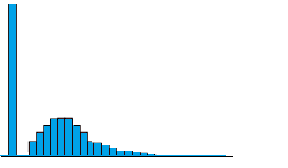

##### This is a photo of our target distribution
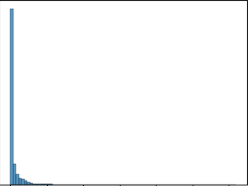

# Using Optuna for getting the best parameters in the model

import optuna
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values of the hyperparameters using a trial object.
    params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
    'num_leaves': trial.suggest_int('num_leaves', 10, 200),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
    'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-4, 1e-1),
    'tweedie_variance_power': trial.suggest_uniform('tweedie_variance_power', 1.0, 2.0),
    'max_depth': trial.suggest_int('max_depth', -1, 15),
    'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-5, 1e2),
    'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
    # Add more hyperparameters to optimize
    }
        
    lgb_model = LGBMRegressor(**params)
    lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=['mae', 'rmse'])

    # Get Tweedie deviance on the test set
    #print(lgb_model.evals_result_['valid_0']['tweedie'])
    #tweedie_deviance_test = lgb_model.evals_result_['valid_0']['tweedie'][-1]
    
    best_mae = lgb_model.best_score_['valid_0']['l1']
    
    return best_mae

study = optuna.create_study(direction='minimize')  # 'minimize' for MSE
study.optimize(objective, n_trials=100)


In [33]:
#best_params = study.best_params
best_params = {'boosting_type': 'gbdt', 'num_leaves': 200, 'learning_rate': 0.0682656012441245, 'feature_fraction': 0.6675045906383925, 'bagging_fraction': 0.892247736523972, 'bagging_freq': 2, 'min_child_samples': 93, 'lambda_l1': 2.4850868431384714e-05, 'lambda_l2': 3.091990009416445e-05, 'min_split_gain': 0.0008484319907001317, 'tweedie_variance_power': 1.8365277946422187, 'max_depth': 12, 'min_child_weight': 1.5010860061242657, 'subsample': 0.5107281519279898, 'colsample_bytree': 0.47411385753013613}
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'learning_rate': 0.0682656012441245, 'feature_fraction': 0.6675045906383925, 'bagging_fraction': 0.892247736523972, 'bagging_freq': 2, 'min_child_samples': 93, 'lambda_l1': 2.4850868431384714e-05, 'lambda_l2': 3.091990009416445e-05, 'min_split_gain': 0.0008484319907001317, 'tweedie_variance_power': 1.8365277946422187, 'max_depth': 12, 'min_child_weight': 1.5010860061242657, 'subsample': 0.5107281519279898, 'colsample_bytree': 0.47411385753013613}


In [34]:
#Model parameters
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(**best_params, random_state= 2023)
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=2.4850868431384714e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4850868431384714e-05
[LightGBM] [Warning] bagging_fraction is set=0.892247736523972, subsample=0.5107281519279898 will be ignored. Current value: bagging_fraction=0.892247736523972
[LightGBM] [Warning] feature_fraction is set=0.6675045906383925, colsample_bytree=0.47411385753013613 will be ignored. Current value: feature_fraction=0.6675045906383925
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.091990009416445e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.091990009416445e-05


LGBMRegressor(bagging_fraction=0.892247736523972, bagging_freq=2,
              colsample_bytree=0.47411385753013613,
              feature_fraction=0.6675045906383925,
              lambda_l1=2.4850868431384714e-05, lambda_l2=3.091990009416445e-05,
              learning_rate=0.0682656012441245, max_depth=12,
              min_child_samples=93, min_child_weight=1.5010860061242657,
              min_split_gain=0.0008484319907001317, num_leaves=200,
              random_state=2023, subsample=0.5107281519279898,
              tweedie_variance_power=1.8365277946422187)

## Feature importances

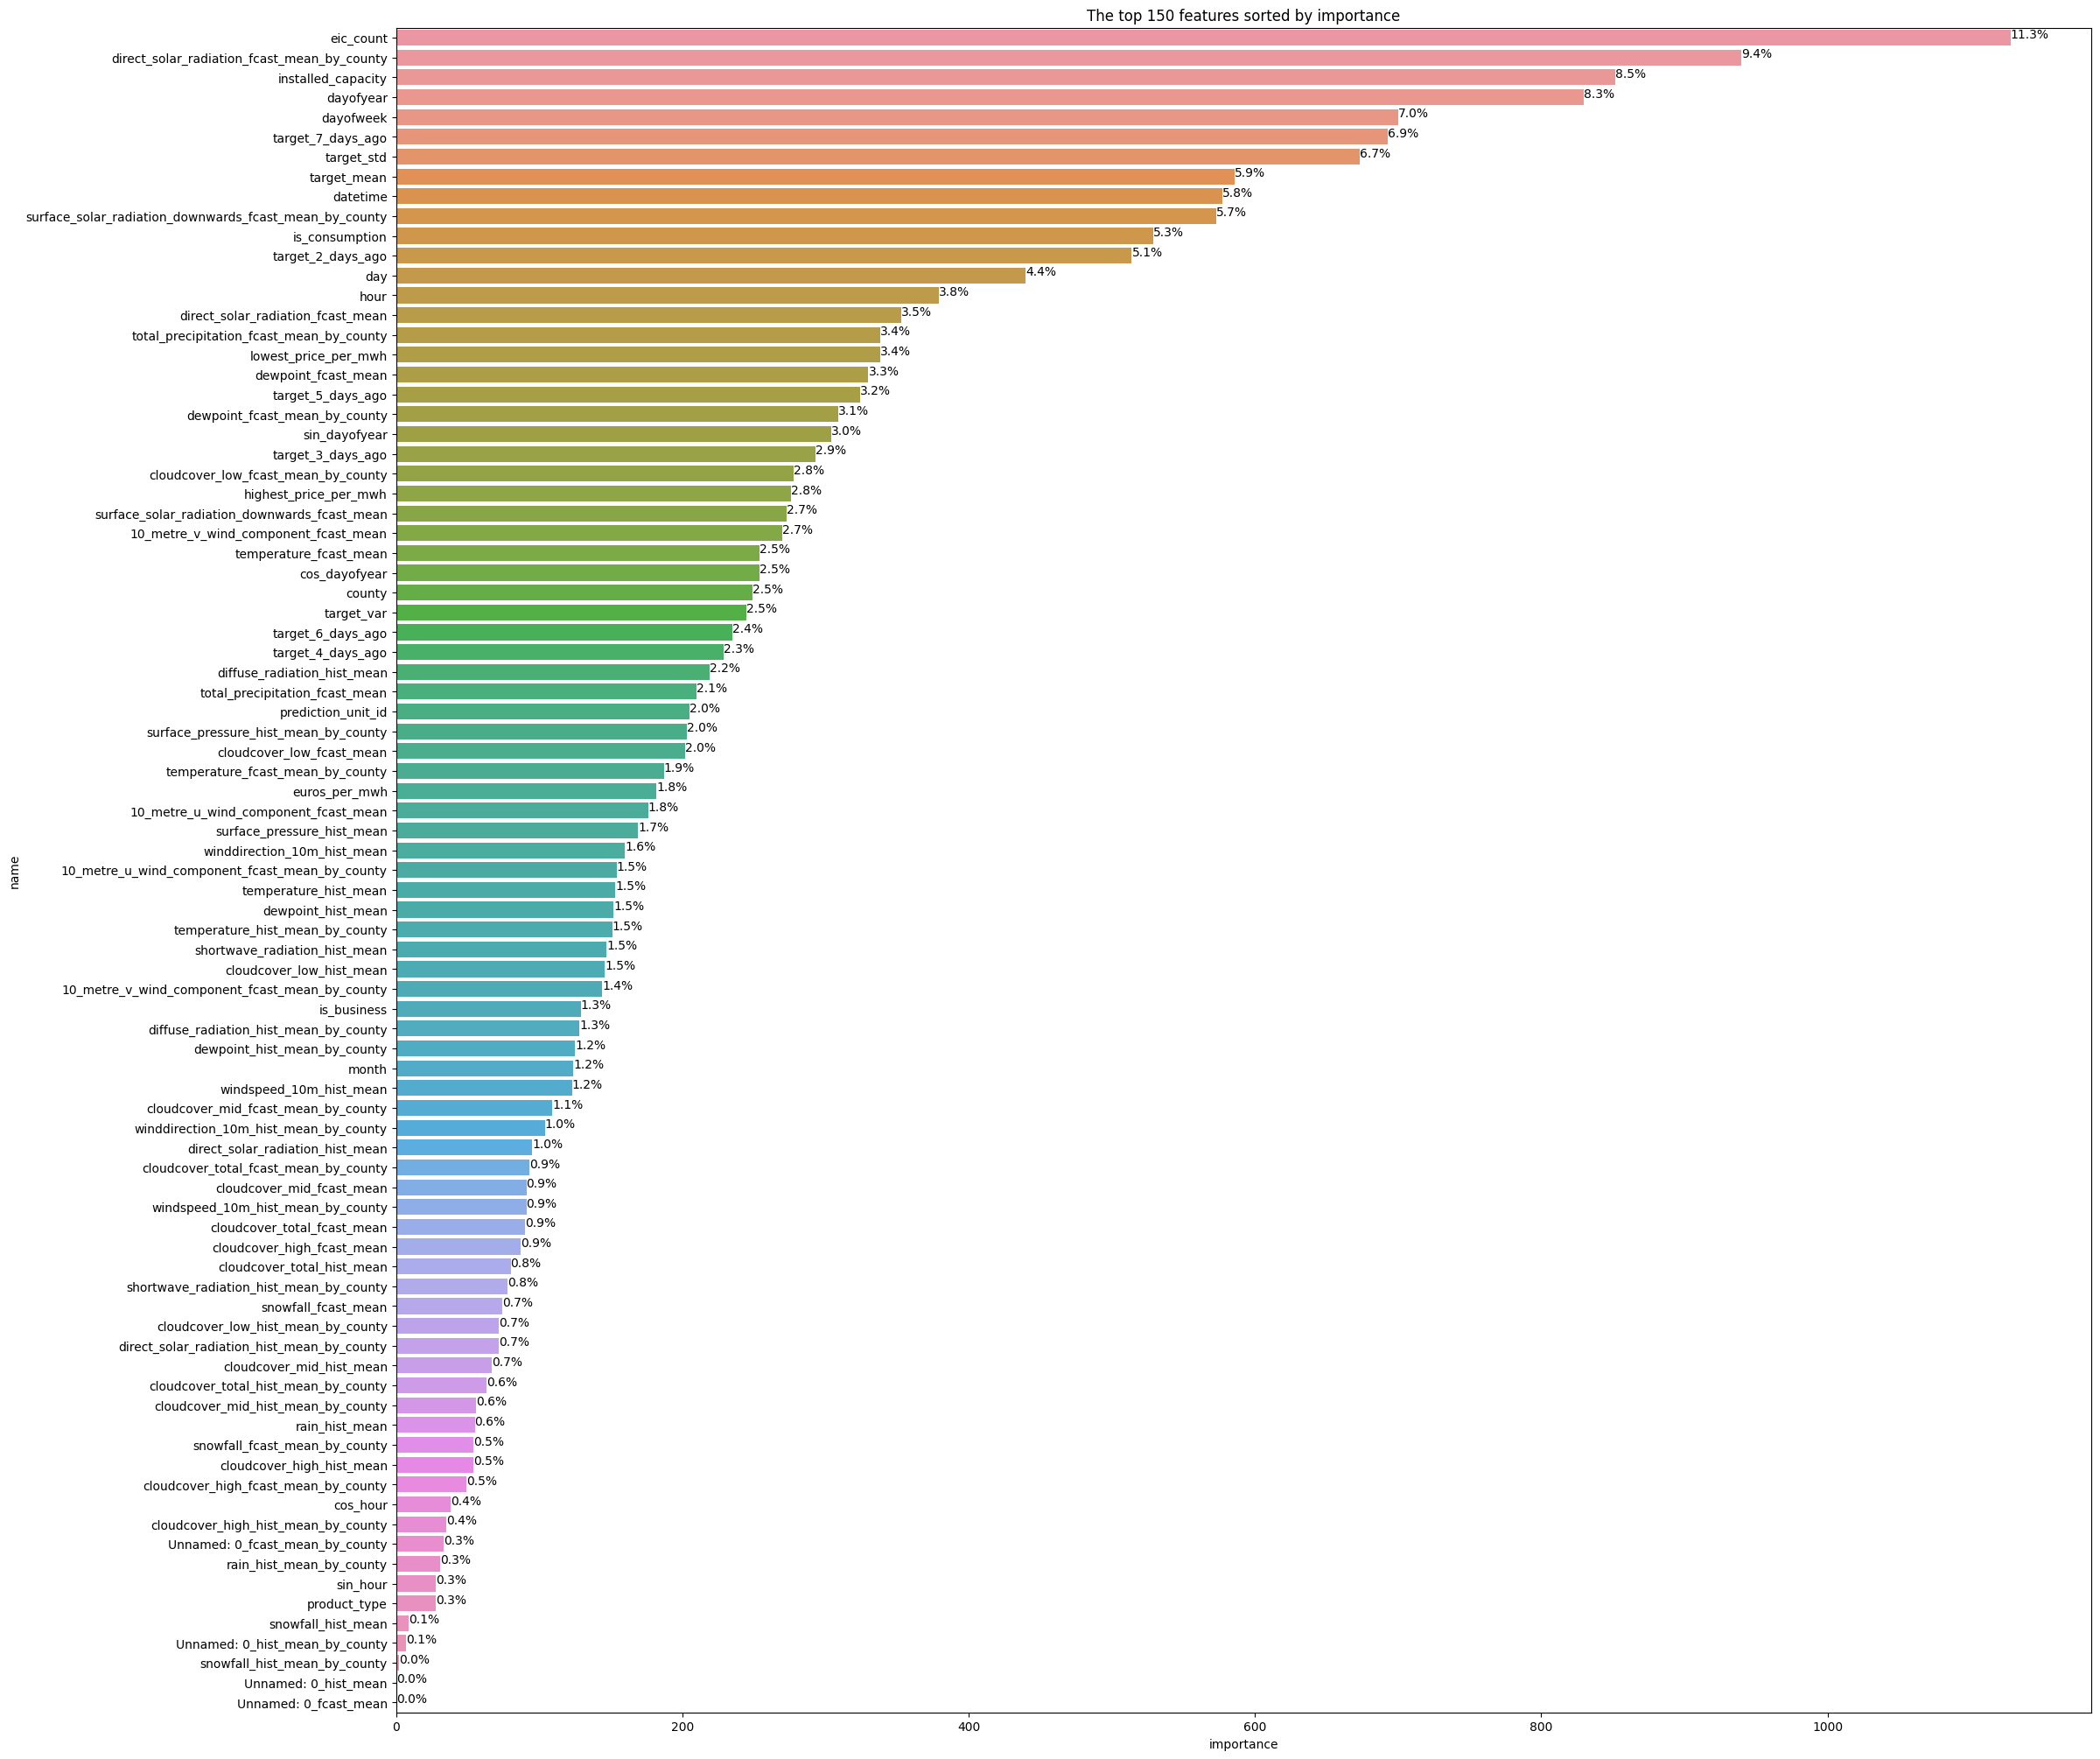

In [35]:
TOP = 150
importance_data = pd.DataFrame({'name': train.drop('target', axis= 1).columns
, 'importance': lgbm.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(25,25))
sns.barplot(data=importance_data,
            x = 'importance',
            y = 'name'
        )
patches = ax.patches
count = 0
for patch in patches:
    height = patch.get_height() 
    width = patch.get_width()
    perc = 0.01*importance_data['importance'].iloc[count]#100*width/len(importance_data)
    ax.text(width, patch.get_y() + height/2, f'{perc:.1f}%')
    count+=1
    
plt.title(f'The top {TOP} features sorted by importance')
plt.show()

In [36]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,month,day,hour,dayofweek,dayofyear,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,temperature_fcast_mean,dewpoint_fcast_mean,cloudcover_high_fcast_mean,cloudcover_low_fcast_mean,cloudcover_mid_fcast_mean,cloudcover_total_fcast_mean,10_metre_u_wind_component_fcast_mean,10_metre_v_wind_component_fcast_mean,direct_solar_radiation_fcast_mean,surface_solar_radiation_downwards_fcast_mean,snowfall_fcast_mean,total_precipitation_fcast_mean,Unnamed: 0_fcast_mean,temperature_fcast_mean_by_county,dewpoint_fcast_mean_by_county,cloudcover_high_fcast_mean_by_county,cloudcover_low_fcast_mean_by_county,cloudcover_mid_fcast_mean_by_county,cloudcover_total_fcast_mean_by_county,10_metre_u_wind_component_fcast_mean_by_county,10_metre_v_wind_component_fcast_mean_by_county,direct_solar_radiation_fcast_mean_by_county,surface_solar_radiation_downwards_fcast_mean_by_county,snowfall_fcast_mean_by_county,total_precipitation_fcast_mean_by_county,Unnamed: 0_fcast_mean_by_county,temperature_hist_mean,dewpoint_hist_mean,rain_hist_mean,snowfall_hist_mean,surface_pressure_hist_mean,cloudcover_total_hist_mean,cloudcover_low_hist_mean,cloudcover_mid_hist_mean,cloudcover_high_hist_mean,windspeed_10m_hist_mean,winddirection_10m_hist_mean,shortwave_radiation_hist_mean,direct_solar_radiation_hist_mean,diffuse_radiation_hist_mean,Unnamed: 0_hist_mean,temperature_hist_mean_by_county,dewpoint_hist_mean_by_county,rain_hist_mean_by_county,snowfall_hist_mean_by_county,surface_pressure_hist_mean_by_county,cloudcover_total_hist_mean_by_county,cloudcover_low_hist_mean_by_county,cloudcover_mid_hist_mean_by_county,cloudcover_high_hist_mean_by_county,windspeed_10m_hist_mean_by_county,winddirection_10m_hist_mean_by_county,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county,Unnamed: 0_hist_mean_by_county,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago,sin_hour,cos_hour,sin_dayofyear,cos_dayofyear,target_mean,target_std,target_var
122,0,0,1,0.079,0,1633046400000000000,0,10,1,0,4,274,127.0,1097.59,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.0,0.0,0.0,0.000069,37.0,9.205896,4.282617,0.132951,0.503769,0.87493,0.965574,-3.168878,4.505805,0.0,0.0,0.0,0.000004,4.5,8.982667,6.233333,0.0,0.0,1026.648,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.6,37.0,8.84,6.71,0.0,0.0,1028.51,93.3,87.6,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,4.5,0.000,0.000,0.000,1.611,0.000,1.150,0.0,0.261799,-0.010814,-0.013333,0.460167,0.727640,0.529460
123,0,0,1,157.470,1,1633046400000000000,0,10,1,0,4,274,127.0,1097.59,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.0,0.0,0.0,0.000069,37.0,9.205896,4.282617,0.132951,0.503769,0.87493,0.965574,-3.168878,4.505805,0.0,0.0,0.0,0.000004,4.5,8.982667,6.233333,0.0,0.0,1026.648,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.6,37.0,8.84,6.71,0.0,0.0,1028.51,93.3,87.6,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,4.5,141.697,137.723,148.158,152.987,136.066,147.270,0.0,0.261799,-0.010814,-0.013333,143.983500,6.578743,43.279859
124,0,0,2,0.000,0,1633046400000000000,1,10,1,0,4,274,18.0,145.40,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.0,0.0,0.0,0.000069,37.0,9.205896,4.282617,0.132951,0.503769,0.87493,0.965574,-3.168878,4.505805,0.0,0.0,0.0,0.000004,4.5,8.982667,6.233333,0.0,0.0,1026.648,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.6,37.0,8.84,6.71,0.0,0.0,1028.51,93.3,87.6,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,4.5,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.261799,-0.010814,-0.013333,0.000000,0.000000,0.000000
125,0,0,2,17.546,1,1633046400000000000,1,10,1,0,4,274,18.0,145.40,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.

In [37]:
from sklearn.metrics import mean_absolute_error

y_pred_test = lgbm.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Mean Absolute Error on Test Set:", mae_test)

Mean Absolute Error on Test Set: 56.31125643094112


## **Test function**

In [38]:
def preTest(data, client, hist_weather, forecast_weather, electricity, gas, locations):
    
    '''Exact same function as the train function but with some tweaks'''
    
    data= data.rename(columns={'prediction_datetime' : 'datetime'})
    data['datetime'] = pd.to_datetime(data['datetime'], utc=True)
        
    electricity = electricity.rename(columns= {'forecast_date' : 'datetime'})
    
    electricity['datetime'] = pd.to_datetime(electricity['datetime'], utc= True)

    #locations = locations.drop('Unnamed: 0', axis= 1) 
        
    forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude', 'longitude']].astype(float).round(1)
        
    forecast_weather= forecast_weather.merge(locations, how='left', on=['longitude','latitude'])
        
    forecast_weather.dropna(axis= 0, inplace= True)    
    
    forecast_weather['county'] = forecast_weather['county'].astype('int64')
    
    forecast_weather.drop(['origin_datetime', 'latitude', 'longitude', 'hours_ahead', 'data_block_id'], axis=1, inplace= True)
    
    forecast_weather.rename(columns={'forecast_datetime': 'datetime'}, inplace= True)
    
    forecast_weather['datetime']= pd.to_datetime(forecast_weather['datetime'], utc= True)
    
    
    forecast_weather_datetime= forecast_weather.groupby([forecast_weather['datetime'].
                                            dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                                            'datetime'], axis= 1)
                                                                     .columns)].mean().reset_index()
    forecast_weather_datetime['datetime']= pd.to_datetime(
        forecast_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    forecast_weather_datetime_county= forecast_weather.groupby(['county',forecast_weather['datetime'].
                              dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                              'datetime'], axis= 1)
                                                       .columns)].mean().reset_index()
    forecast_weather_datetime_county['datetime']= pd.to_datetime(
        forecast_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)

                
    hist_weather[['latitude', 'longitude']] = hist_weather[['latitude', 'longitude']].astype(float).round(1)

    hist_weather= hist_weather.merge(locations, how='left', on=['longitude','latitude'])    
    
    hist_weather.dropna(axis= 0, inplace= True)
    
    hist_weather.drop(['latitude', 'longitude'], axis=1, inplace= True)

    hist_weather['county'] = hist_weather['county'].astype('int64')
            
    hist_weather['datetime']= pd.to_datetime(hist_weather['datetime'], utc= True)
    
    
    hist_weather_datetime= hist_weather.groupby([hist_weather['datetime'].
                                            dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                                            'datetime', 'data_block_id'], axis= 1)
                                                                     .columns)].mean().reset_index()    
    
    hist_weather_datetime['datetime']= pd.to_datetime(hist_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    hist_weather_datetime= hist_weather_datetime.merge(hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    
    hist_weather_datetime_county= hist_weather.groupby(['county',hist_weather['datetime'].
                              dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                              'datetime', 'data_block_id'], axis= 1)
                                                       .columns)].mean().reset_index() 
    hist_weather_datetime_county['datetime']= pd.to_datetime(hist_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)
    hist_weather_datetime_county= hist_weather_datetime_county.merge(hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    data['year'] = data['datetime'].dt.year
    
    data['month'] = data['datetime'].dt.month
    
    data['day'] = data['datetime'].dt.day
    
    data['hour'] = data['datetime'].dt.hour
    
    data['dayofweek']= data['datetime'].dt.dayofweek

    data['dayofyear']= data['datetime'].dt.dayofyear

        
    electricity['hour'] = electricity['datetime'].dt.hour

    
    data= data.merge(client.drop(columns = ['date']), how='left', on=['data_block_id', 'county', 'is_business', 'product_type'])

    data= data.merge(gas[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    
    data= data.merge(electricity[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour', 'data_block_id'])

    data= data.merge(forecast_weather_datetime, how='left', on=['datetime'])
    
    data= data.merge(forecast_weather_datetime_county, how='left', on=['datetime', 'county'],
                     suffixes= ('_fcast_mean','_fcast_mean_by_county'))
    
    
    hist_weather_datetime['hour']= hist_weather_datetime['datetime'].dt.hour
    hist_weather_datetime_county['hour']= hist_weather_datetime_county['datetime'].dt.hour

    hist_weather_datetime.drop_duplicates(inplace=True)
    hist_weather_datetime_county.drop_duplicates(inplace=True)
    hist_weather_datetime.drop('datetime', axis= 1, inplace= True)
    hist_weather_datetime_county.drop('datetime', axis= 1, inplace= True)

    
    data= data.merge(hist_weather_datetime, how='left', on=['data_block_id', 'hour'])



    data= data.merge(hist_weather_datetime_county, how='left', on=['data_block_id', 'county', 'hour'],
                     suffixes= ('_hist_mean','_hist_mean_by_county'))

    data= data.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()

    data.drop([ 'level_0','level_1','row_id', 'data_block_id', 'year'], axis= 1, inplace= True)
    
    return data

In [39]:
def create_revealed_targets_test(data, previous_revealed_targets, N_day_lags):
    '''🎯 Create new test data based on previous_revealed_targets and N_day_lags 🎯 ''' 
    for count, revealed_targets in enumerate(previous_revealed_targets) :
        day_lag = count + 2
        
        # Get hour
        revealed_targets['hour'] = pd.to_datetime(revealed_targets['datetime'], utc= True).dt.hour
        
        # Select columns and rename target
        revealed_targets = revealed_targets[['hour', 'prediction_unit_id', 'is_consumption', 'target']]
        revealed_targets = revealed_targets.rename(columns = {"target" : f"target_{day_lag}_days_ago"})
        
        
        # Add past revealed targets
        data = pd.merge(data,
                        revealed_targets,
                        how = 'left',
                        on = ['hour', 'prediction_unit_id', 'is_consumption'],
                       )
        
    # If revealed_target_columns not available, replace by nan
    all_revealed_columns = [f"target_{day_lag}_days_ago" for day_lag in range(2, N_day_lags+1)]
    missing_columns = list(set(all_revealed_columns) - set(data.columns))
    data[missing_columns] = np.nan 
    
    return data

## **Submission**

In [40]:
previous_revealed_targets = []
env = enefit.make_env()
iter_test = env.iter_test()
for (test, revealed_targets, client_test, historical_weather_test,
     forecast_weather_test, electricity_test, gas_test,sample_prediction) in iter_test:
    
    # Rename test set to make consistent with train
    test = test.rename(columns = {'prediction_datetime': 'datetime'})
    
    # Initiate column data_block_id with default value to merge the data on
    id_column = 'data_block_id' 
    
    test[id_column] = 0
    gas_test[id_column] = 0
    electricity_test[id_column] = 0
    historical_weather_test[id_column] = 0
    forecast_weather_test[id_column] = 0
    client_test[id_column] = 0
    revealed_targets[id_column] = 0
    
    data_test = preTest(test, client_test, historical_weather_test,
                        forecast_weather_test, electricity_test, gas_test, locations)
    
    data_test['datetime']= pd.to_datetime(data_test['datetime'], utc= True).astype('int64')
    
    # Store revealed_targets
    previous_revealed_targets.insert(0, revealed_targets)
    if len(previous_revealed_targets) == N_day_lags:
        previous_revealed_targets.pop()
    
    # Add previous revealed targets
    df_test = create_revealed_targets_test(data = data_test.copy(),
                                           previous_revealed_targets = previous_revealed_targets.copy(),
                                           N_day_lags = N_day_lags
                                          )
    #Data Transformation
    df_test['sin_hour']= (np.pi * np.sin(df_test['hour']) / 12)
    df_test['cos_hour']= (np.pi * np.cos(df_test['hour']) / 12)
    df_test['sin_hour']= (np.pi * np.sin(df_test['hour']) / 12)
    df_test['cos_hour']= (np.pi * np.cos(df_test['hour']) / 12)
    df_test['sin_dayofyear']= (np.pi * np.sin(df_test['dayofyear']) / 183)
    df_test['cos_dayofyear']= (np.pi * np.cos(df_test['dayofyear']) / 183)
    df_test['target_mean']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].mean(1)
    df_test['target_std']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].std(1)
    df_test['target_var']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].var(1)
    
    
    X_test = df_test.drop('currently_scored', axis= 1).values

    #Predictions
    test['target'] = lgbm.predict(X_test).clip(0)
    #test.loc[test['is_consumption']==0, "target"] = test.loc[test['is_consumption']==0, "target_solar"]  
    sample_prediction["target"] = test['target']
    
    #Sending predictions to the API
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
